In [71]:

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import uniform
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from src.plants_sm.unsupervised.pca import SklearnPCA
from src.plants_sm.unsupervised.tsne import SklearnTSNE

In [72]:

# divisão dos dados
df = pd.read_csv("../data/train_set.tsv")
X_train = df.iloc[:, slice(8, -1)]
y_train = df.iloc[:, -1]
y_train_binary = y_train.replace(['GM', 'SM'], [0, 1])

/tmp/ipykernel_53892/2692150009.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/train_set.tsv")


In [182]:
y_train

0       GM
1       GM
2       GM
3       GM
4       GM
        ..
1625    SM
1626    SM
1627    SM
1628    SM
1629    SM
Name: class, Length: 1630, dtype: object

In [183]:
colname = X_train.columns
colname

Index(['length', 'charge', 'charge_density', 'formulaC', 'formulaH',
       'formulaN', 'formulaO', 'formulaS', 'total_bonds', 'hydrogen_bonds',
       ...
       'crosscorr_6', 'moment', 'global', 'profile_0', 'profile_1', 'arc_0',
       'arc_1', 'arc_2', 'arc_3', 'arc_4'],
      dtype='object', length=2107)

In [73]:
from sklearn.preprocessing import StandardScaler
# CONSENSO
import os
import pickle as pkl


os.makedirs("./models_all_features/", exist_ok=True)

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

pkl.dump(scaler,open("./models_all_features/scaler", "wb"))

# X_train

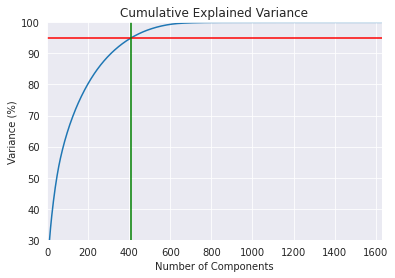

First 2 PC: 11.727706913634396
First 411 PC: 95.0355660301825


In [74]:
# Load Data
pca = SklearnPCA(n_components = 1630)

# Transform the data
df_pca = pca.fit(X_train)

pca.generate_pca_variance_plot()

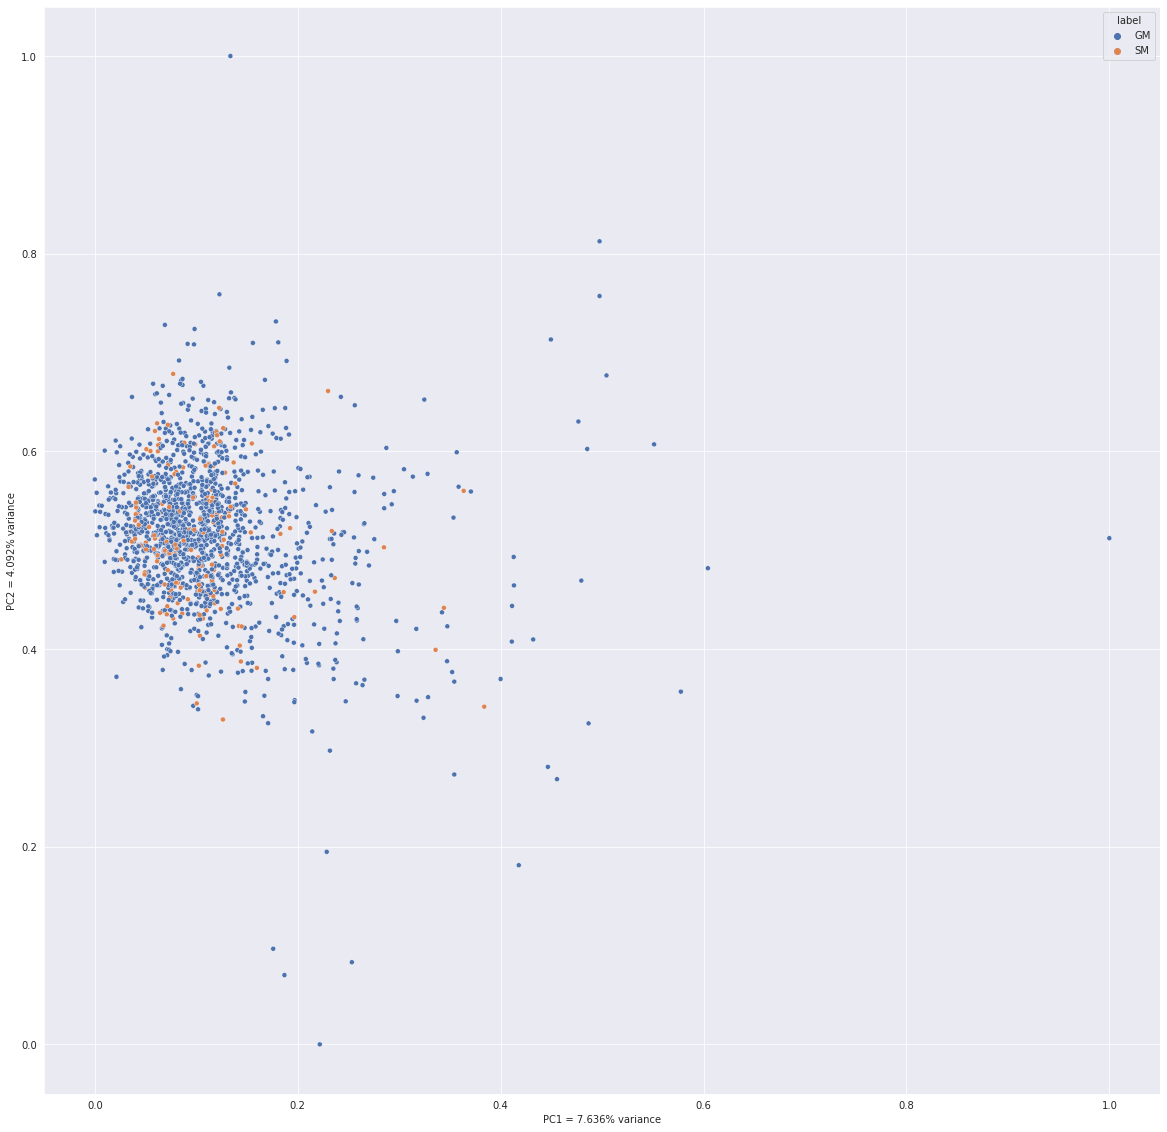

In [75]:
pca.generate_dotplot(X_train, y_train)

/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'TSNE'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>

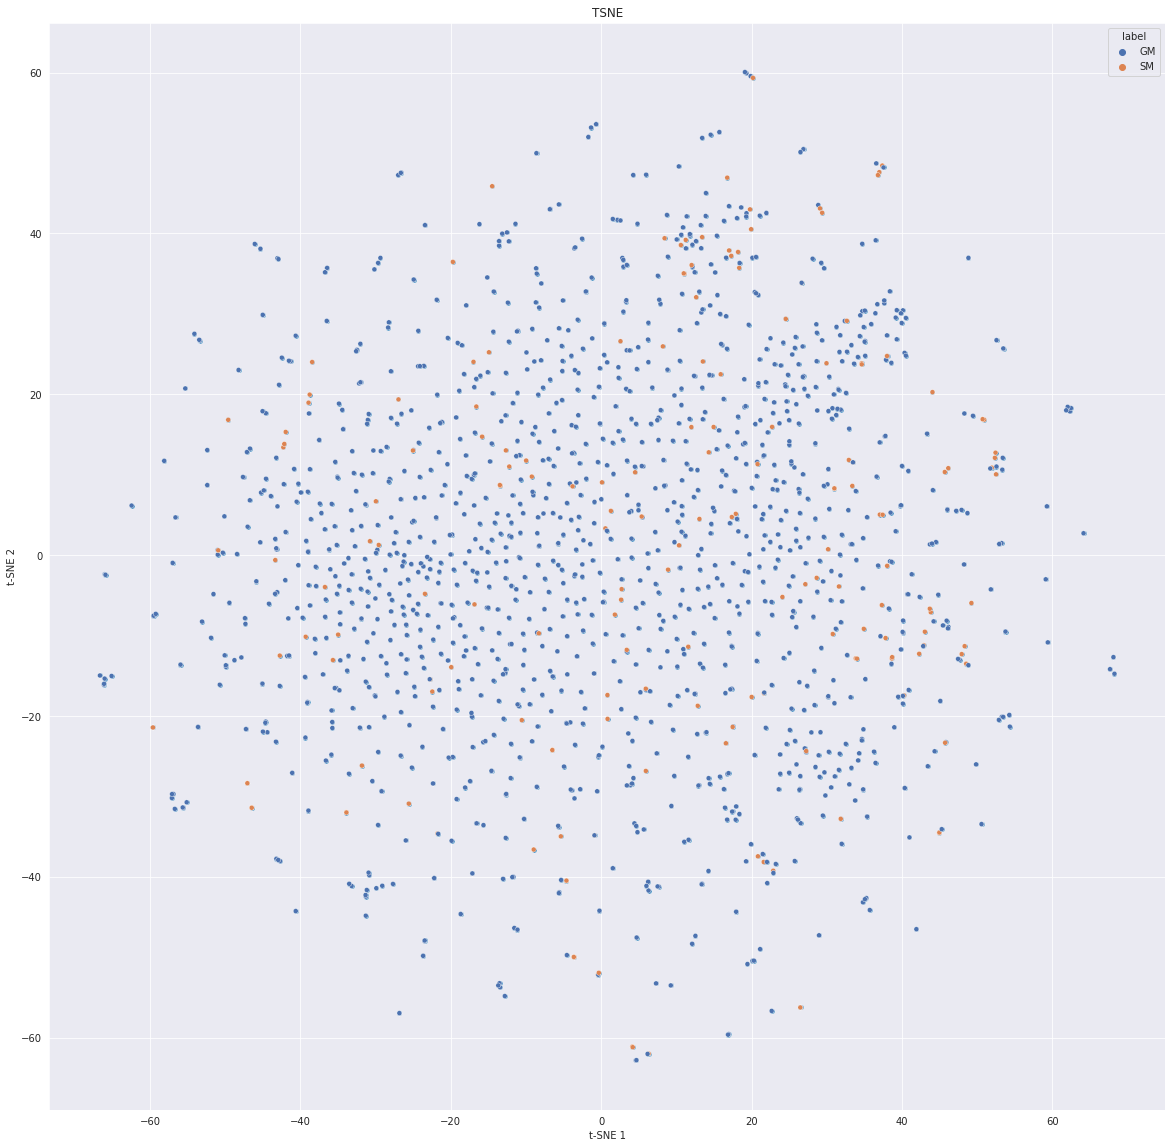

In [36]:
tsne = SklearnTSNE()
tsne_data = tsne.fit_transform(X_train)
tsne.generate_dotplot(tsne_data, y_train)

# Machine Learning


# Funções para otimização do modelo e escrever resultados

In [77]:



def score_test_set(model, X_test_param, y_test_param):
    # score test set
    y_pred = model.predict(X_test_param)
    print('accuracy', accuracy_score(y_test_param, y_pred))
    print('MCC', matthews_corrcoef(y_test_param, y_pred))
    print('f1 score', f1_score(y_test_param, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test_param, y_pred).ravel()
    print('fdr', float(fp) / (tp + fp))
    print('sn', float(tp) / (tp + fn))
    print('sp', float(tn) / (tn + fp))

    print(confusion_matrix(y_test_param, y_pred))
    print(classification_report(y_test_param, y_pred))
    preds = model.predict_proba(X_test_param)[:,1]
    fpr, tpr, threshold = roc_curve(y_test_param, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print('ROC AUC score:', round(roc_auc, 4))

In [27]:
# Comparar os modelos com e sem pesos

In [79]:
#Test and compare multiple models

models = {'LR': LogisticRegression(max_iter=1000),
          'LR-W': LogisticRegression(class_weight={0: 1, 1: 8}, max_iter=1000),
          'RF': RandomForestClassifier(),
          'RF-W': RandomForestClassifier(class_weight={0: 1, 1: 8}),
          'KNN': KNeighborsClassifier(),
          'SVM': SVC(probability=True),
          'SVM-W': SVC(class_weight={0: 1, 1: 8}, probability=True),
          'DT': DecisionTreeClassifier(),
          'DT-W': DecisionTreeClassifier(class_weight={0: 1, 1: 8})}


names = []
results = []
for name in models:
    kfold = model_selection.KFold(n_splits=7, shuffle=True, random_state=123)
    cross_val = model_selection.cross_val_score(models[name], X_train, y_train_binary,
                                                cv=kfold, scoring='f1')
    models[name].fit(X_train, y_train_binary)
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)


LR: 0.226034 SD:0.073366
LR-W: 0.269146 SD:0.057152
RF: 0.020786 SD:0.032873
RF-W: 0.010204 SD:0.024995
KNN: 0.088405 SD:0.048751
SVM: 0.000000 SD:0.000000
SVM-W: 0.332447 SD:0.088810
DT: 0.155663 SD:0.067648
DT-W: 0.153398 SD:0.057490


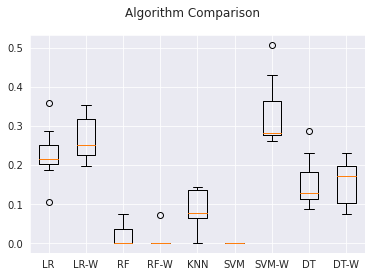

In [80]:
# Plot the results
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# TEST SET


In [81]:
# divisão dos dados
df = pd.read_csv("../data/test_set.tsv")
X_test = df.iloc[:, slice(8, -1)]
y_test = df.iloc[:, -1]

# normalização dos dados
X_test = scaler.transform(X_test)
y_test_binary = y_test.replace(['GM', 'SM'], [0, 1])
X_test

array([[0.20775112, 0.41604381, 0.49246773, ..., 0.42857143, 0.18181818,
        0.6       ],
       [0.21196942, 0.4230083 , 0.49793417, ..., 0.42857143, 0.18181818,
        0.4       ],
       [0.13656736, 0.51285089, 0.54640046, ..., 0.28571429, 0.18181818,
        0.4       ],
       ...,
       [0.07012919, 0.56895946, 0.62576673, ..., 0.28571429, 0.09090909,
        0.4       ],
       [0.15844978, 0.60875555, 0.62438182, ..., 0.28571429, 0.09090909,
        0.4       ],
       [0.10730293, 0.67023732, 0.72465191, ..., 0.57142857, 0.18181818,
        0.4       ]])

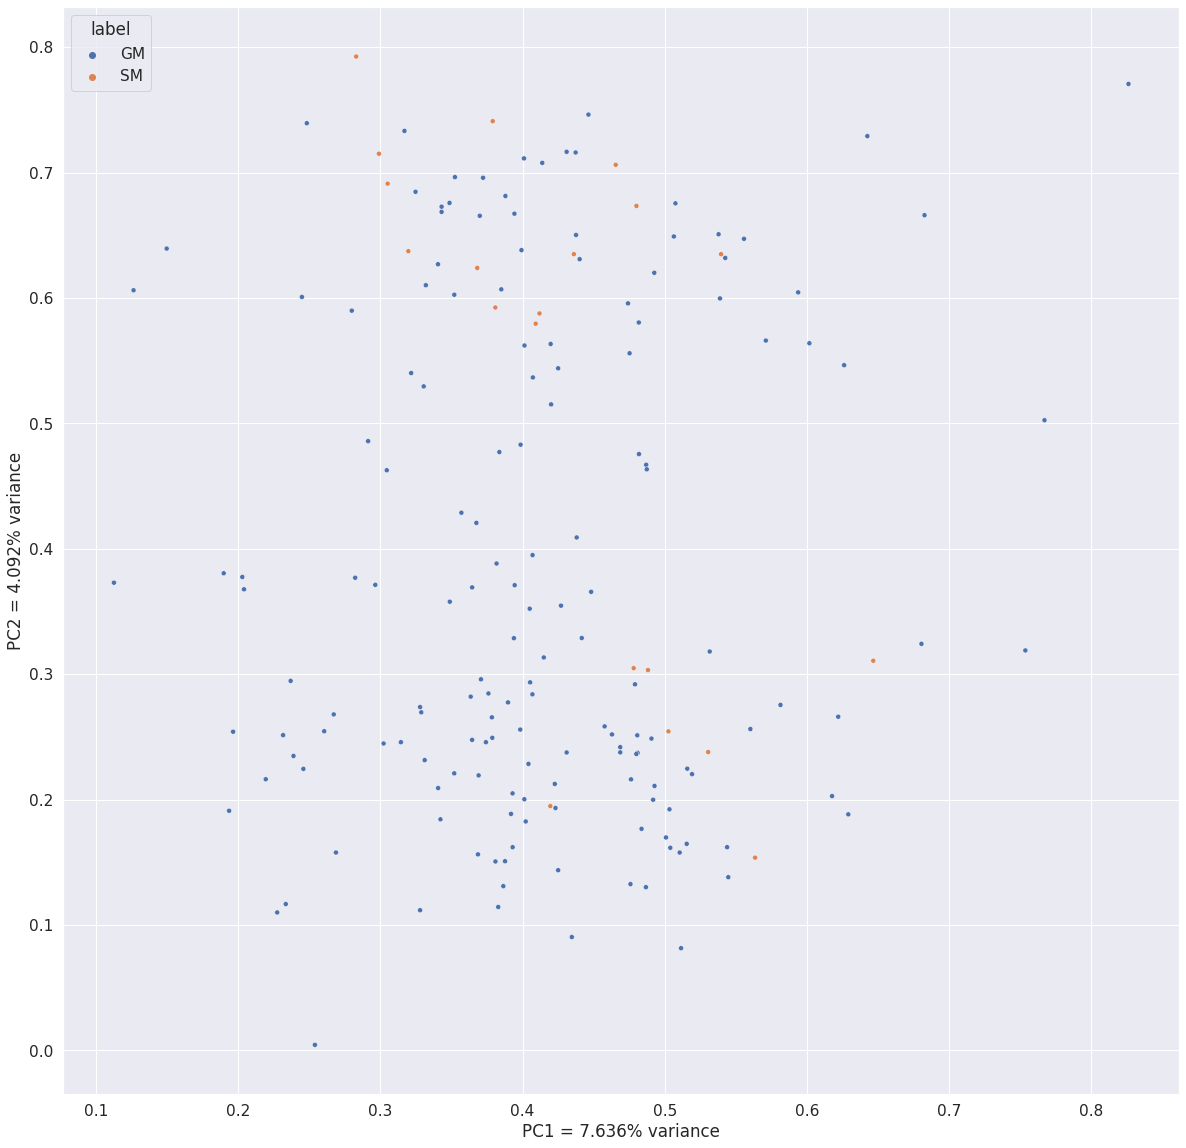

In [211]:
# PCA

pca.generate_dotplot(X_test, y_test)

In [43]:
y_test_binary

0      0
1      0
2      0
3      0
4      0
      ..
177    1
178    1
179    1
180    1
181    1
Name: class, Length: 182, dtype: int64

# Modelos e curva ROC test


-------------------------
Model: LR
accuracy 0.8681318681318682
MCC 0.1465680703752256
f1 score 0.2
fdr 0.7
sn 0.15
sp 0.9567901234567902
[[155   7]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       162
           1       0.30      0.15      0.20        20

    accuracy                           0.87       182
   macro avg       0.60      0.55      0.56       182
weighted avg       0.84      0.87      0.85       182



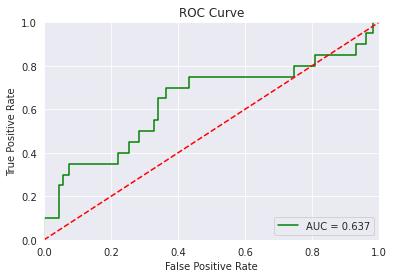

ROC AUC score: 0.6373
-------------------------


-------------------------
Model: LR-W
accuracy 0.7967032967032966
MCC 0.1679329521495693
f1 score 0.2745098039215686
fdr 0.7741935483870968
sn 0.35
sp 0.8518518518518519
[[138  24]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       162
           1       0.23      0.35      0.27        20

    accuracy                           0.80       182
   macro avg       0.57      0.60      0.58       182
weighted avg       0.84      0.80      0.82       182



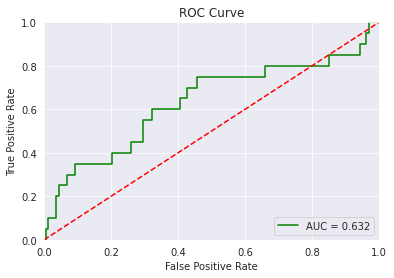

ROC AUC score: 0.6324
-------------------------


-------------------------
Model: RF
accuracy 0.8901098901098901
MCC 0.13148148148148148
f1 score 0.09090909090909091
fdr 0.5
sn 0.05
sp 0.9938271604938271
[[161   1]
 [ 19   1]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       162
           1       0.50      0.05      0.09        20

    accuracy                           0.89       182
   macro avg       0.70      0.52      0.52       182
weighted avg       0.85      0.89      0.85       182



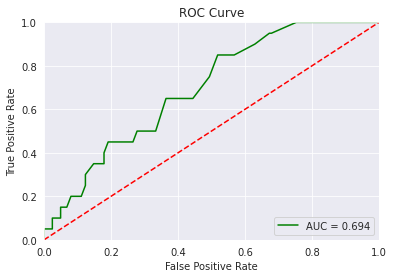

ROC AUC score: 0.6938
-------------------------


-------------------------
Model: RF-W
accuracy 0.8901098901098901
MCC 0.0
f1 score 0.0
fdr nan
sn 0.0
sp 1.0
[[162   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       162
           1       0.00      0.00      0.00        20

    accuracy                           0.89       182
   macro avg       0.45      0.50      0.47       182
weighted avg       0.79      0.89      0.84       182



/tmp/ipykernel_53892/3489843612.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('fdr', float(fp) / (tp + fp))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no p

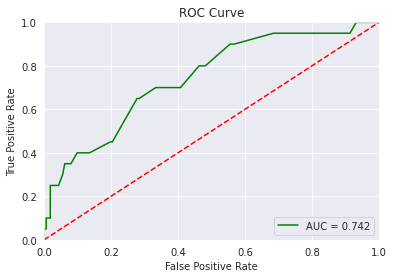

ROC AUC score: 0.7423
-------------------------


-------------------------
Model: KNN
accuracy 0.8901098901098901
MCC 0.1869845993496577
f1 score 0.16666666666666669
fdr 0.5
sn 0.1
sp 0.9876543209876543
[[160   2]
 [ 18   2]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       162
           1       0.50      0.10      0.17        20

    accuracy                           0.89       182
   macro avg       0.70      0.54      0.55       182
weighted avg       0.86      0.89      0.86       182



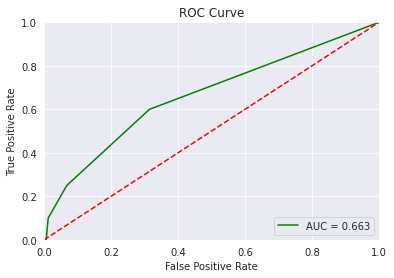

ROC AUC score: 0.6631
-------------------------


-------------------------
Model: SVM
accuracy 0.8901098901098901
MCC 0.0
f1 score 0.0
fdr nan
sn 0.0
sp 1.0
[[162   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       162
           1       0.00      0.00      0.00        20

    accuracy                           0.89       182
   macro avg       0.45      0.50      0.47       182
weighted avg       0.79      0.89      0.84       182



/tmp/ipykernel_53892/3489843612.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('fdr', float(fp) / (tp + fp))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no p

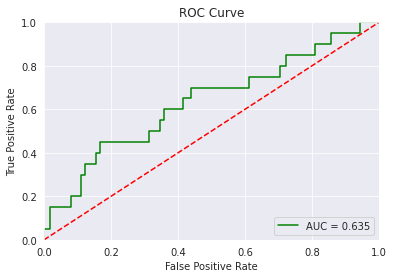

ROC AUC score: 0.6349
-------------------------


-------------------------
Model: SVM-W
accuracy 0.7857142857142857
MCC 0.21538674267508798
f1 score 0.3157894736842105
fdr 0.7567567567567568
sn 0.45
sp 0.8271604938271605
[[134  28]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       162
           1       0.24      0.45      0.32        20

    accuracy                           0.79       182
   macro avg       0.58      0.64      0.59       182
weighted avg       0.85      0.79      0.81       182



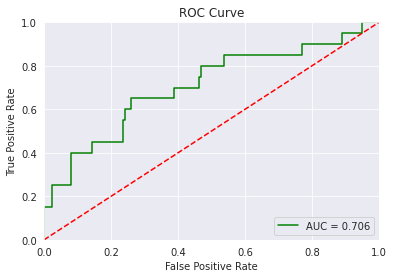

ROC AUC score: 0.7065
-------------------------


-------------------------
Model: DT
accuracy 0.8241758241758241
MCC 0.06014260880238035
f1 score 0.15789473684210525
fdr 0.8333333333333334
sn 0.15
sp 0.9074074074074074
[[147  15]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       162
           1       0.17      0.15      0.16        20

    accuracy                           0.82       182
   macro avg       0.53      0.53      0.53       182
weighted avg       0.82      0.82      0.82       182



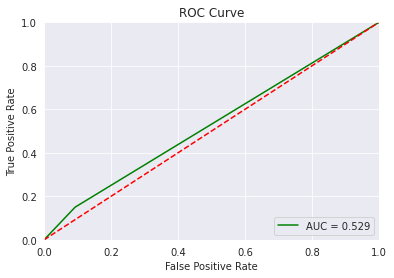

ROC AUC score: 0.5287
-------------------------


-------------------------
Model: DT-W
accuracy 0.8516483516483516
MCC 0.15023371227978286
f1 score 0.2285714285714286
fdr 0.7333333333333333
sn 0.2
sp 0.9320987654320988
[[151  11]
 [ 16   4]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       162
           1       0.27      0.20      0.23        20

    accuracy                           0.85       182
   macro avg       0.59      0.57      0.57       182
weighted avg       0.83      0.85      0.84       182



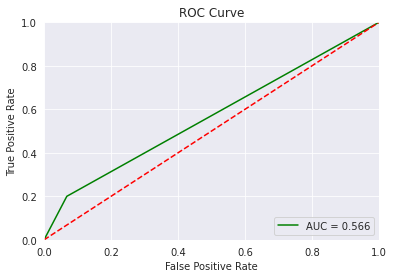

ROC AUC score: 0.566
-------------------------



In [84]:
for model in models:
    print()
    print("-------------------------")
    print(f"Model: {model}")
    score_test_set(models[model], X_test, y_test_binary)
    print("-------------------------")
    print()


# Hyperaparameter Tuning

In [85]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
import json
import os
import pickle as pkl

def create_files_and_folders(randomized_search, folder, model_name):
    os.makedirs(folder, exist_ok=True)

    model_folder = os.path.join(folder, model_name)
    os.makedirs(model_folder, exist_ok=True)

    pkl.dump(randomized_search.best_estimator_, open(os.path.join(model_folder, model_name), "wb"))
    json.dump(randomized_search.best_params_, open(os.path.join(model_folder, f"{model_name}.json"), "w"))

def generate_results(randomized_search, X_test, y_test, folder, model_name):

    if os.path.exists(os.path.join(folder, "models_results.csv")):
        results_df = pd.read_csv(os.path.join(folder, "models_results.csv"), index_col="model")
    else:
        results_df = pd.DataFrame(columns=["model"])
        results_df.set_index("model", inplace=True)

    randomized_cv_results = {"model": [model_name]}
    randomized_cv_results.update(randomized_search.cv_results_)
    for cv_result in randomized_search.cv_results_:
        randomized_cv_results[cv_result] = [randomized_cv_results[cv_result][randomized_search.best_index_]]
    y_test_predicted = randomized_search.predict(X_test)

    f1 = f1_score(y_test, y_test_predicted)
    balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)
    roc_auc = roc_auc_score(y_test, y_test_predicted)
    precision = precision_score(y_test, y_test_predicted)
    recall = recall_score(y_test, y_test_predicted)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_predicted).ravel()
    false_positive_rate = float(fp) / (tn + fp)
    false_negative_rate = float(fn) / (fn + tp)
    sensitivity = float(tp) / (tp + fn)
    specificity = float(tn) / (tn + fp)


    randomized_cv_results["f1_test"] = [f1]
    randomized_cv_results["balanced_accuracy_test"] = [balanced_accuracy]
    randomized_cv_results["roc_auc_test"] = [roc_auc]
    randomized_cv_results["precision_test"] = [precision]
    randomized_cv_results["recall_test"] = [recall]
    randomized_cv_results["false_positive_rate_test"] = [false_positive_rate]
    randomized_cv_results["false_negative_rate_test"] = [false_negative_rate]
    randomized_cv_results["sensitivity_test"] = [sensitivity]
    randomized_cv_results["specificity_test"] = [specificity]
    randomized_cv_results = pd.DataFrame(randomized_cv_results)
    randomized_cv_results.set_index("model", inplace=True)

    if model_name in list(results_df.index):
        results_df.update(randomized_cv_results)
    else:
        results_df = pd.concat((results_df, randomized_cv_results), axis=0)

    results_df.to_csv(os.path.join(folder, "models_results.csv"))

def optimize_hyperparameters(model, params, X_train, y_train, X_test, y_test, folder, model_name):

    randomized_search = RandomizedSearchCV(model, params, cv=7, refit = "f1", verbose = 1,
                                   n_jobs = 8, n_iter=50, random_state=43, scoring=["f1", "balanced_accuracy", "roc_auc", "precision", "recall"])
    randomized_search.fit(X_train, y_train)

    create_files_and_folders(randomized_search, folder, model_name)

    generate_results(randomized_search, X_test, y_test, folder, model_name)

## SVM

In [88]:

param_grid = {'C': [0.0001,0.001,0.01,0.1,1],
              'kernel': ['linear', 'rbf'],
              'degree': [1, 3, 5, 7, 9],
              'gamma': ['scale', 'auto'],
              "class_weight": [{0: 1, 1: 8}],
              "probability": [True]
              }

#hyperparameter optimization algorithm
optimize_hyperparameters(SVC(), param_grid, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "svm_weighted")

Fitting 7 folds for each of 50 candidates, totalling 350 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn

In [89]:
param_grid = {'C': [0.0001,0.001,0.01,0.1,1],
              'kernel': ['linear', 'rbf'],
              'degree': [1, 3, 5, 7, 9],
              'gamma': ['scale', 'auto'],
              "probability": [True]
              }

#hyperparameter optimization algorithm
optimize_hyperparameters(SVC(), param_grid, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "svm")

Fitting 7 folds for each of 50 candidates, totalling 350 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn

# Regressao logistica

In [86]:


distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'],
                     solver=['liblinear'],
                     tol = uniform(loc=1e-5, scale=1e-2),
                     max_iter = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
                     dual= [False],
                     class_weight = [{0: 1, 1: 8}],
                     )

optimize_hyperparameters(LogisticRegression(), distributions, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "lr_weighted")


Fitting 7 folds for each of 50 candidates, totalling 350 fits


In [87]:
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'],
                     solver=['liblinear'],
                     tol = uniform(loc=1e-5, scale=1e-2),
                     max_iter = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
                     dual= [False],
                     )

optimize_hyperparameters(LogisticRegression(), distributions, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "lr")

Fitting 7 folds for each of 50 candidates, totalling 350 fits


### RandomForest com pesos

In [68]:
param_grid = {"bootstrap": [True, False],
               "max_depth": [6, 8, 10, 12, 14],
               "max_features": ['auto', 'sqrt', 'log2'],
               "min_samples_leaf": [2, 3, 4],
               "min_samples_split": [2, 3, 4, 5],
               "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
               "class_weight": [{0: 1, 1: 8}]
               }

#hyperparameter optimization algorithm
optimize_hyperparameters(RandomForestClassifier(), param_grid, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "random_forest_weighted")


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFo

In [ ]:
## Random Forest sem peso

In [90]:
param_grid = {"bootstrap": [True, False],
              "max_depth": [6, 8, 10, 12, 14],
              "max_features": ['auto', 'sqrt', 'log2'],
              "min_samples_leaf": [2, 3, 4],
              "min_samples_split": [2, 3, 4, 5],
              "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
              }

#hyperparameter optimization algorithm
optimize_hyperparameters(RandomForestClassifier(), param_grid, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "random_forest")



Fitting 7 folds for each of 50 candidates, totalling 350 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn

### KNN sem pesos

In [91]:
from sklearn.neighbors import KNeighborsClassifier

params = {

    "n_neighbors": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "leaf_size": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "p": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev']

}

optimize_hyperparameters(KNeighborsClassifier(), params, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "knn")

Fitting 7 folds for each of 50 candidates, totalling 350 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn

# Decision Tree

In [92]:
params = {

    "criterion": ['gini', 'entropy'],
    "splitter":  ['best', 'random'],
    "max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_weight_fraction_leaf": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "max_features": ['auto', 'sqrt', 'log2'],
    "max_leaf_nodes": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_impurity_decrease": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "class_weight": [{0:1, 1:8}]

}


optimize_hyperparameters(DecisionTreeClassifier(), params, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "decision_tree_weighted")

Fitting 7 folds for each of 50 candidates, totalling 350 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn

In [93]:
params = {

    "criterion": ['gini', 'entropy'],
    "splitter":  ['best', 'random'],
    "max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_weight_fraction_leaf": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "max_features": ['auto', 'sqrt', 'log2'],
    "max_leaf_nodes": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "min_impurity_decrease": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],

}


optimize_hyperparameters(DecisionTreeClassifier(), params, X_train, y_train_binary, X_test, y_test_binary, "./models_all_features/", "decision_tree")

Fitting 7 folds for each of 50 candidates, totalling 350 fits


/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/joao/anaconda3/envs/test2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being